In [ ]:
%%html
<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at 'In [13]'.</span>

An Exception was encountered at 'In [13]'.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
CENTERNET_TASK = "ctdet"
CENTERNET_MODEL_PATH = "/home/adrian/projects/CenterNet/models/ctdet_coco_dla_2x.pth"

data_dir='/home/adrian/data'
data_split='val2017'
annFile=f'{data_dir}/coco/annotations/instances_{data_split}.json'

classes = ("person", "dog", "motorcycle", "bear")

import sys
sys.path.extend([
    "/home/adrian/projects/CenterNet/src",
    "/home/adrian/projects/CenterNet/src/centernet/models/networks/DCNv2"
])

from centernet.detectors.detector_factory import detector_factory
from centernet.opts import opts

opt = opts().init([
    CENTERNET_TASK,
    "--load_model", CENTERNET_MODEL_PATH
])
import torch
detector = detector_factory[opt.task](opt)

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on arbitrary images, with focus on persons.

In [3]:
import torch.utils.data as data
from PIL import Image
import os
from datasets import ImageDataset, COCODataset

We will extract image metadata from the annotation file.
Then, we will put matching image files into their respective subfolders
in the dataset's directory.

for klass in classes:
    %mkdir $data_dir/coconut/$klass -p
    catIds = coco.getCatIds(catNms=[klass])
    imgIds = coco.getImgIds(catIds=catIds)
    imgs = coco.loadImgs(imgIds)
    
    for imginfo in imgs:
        %cp $data_dir/coco/$data_split/{imginfo['file_name']} $data_dir/coconut/$klass/

In [4]:
from torchvision import transforms
import torch.nn.functional as F
import torch

def pad_to_size(img: torch.Tensor, size):
    padded = torch.zeros(img.shape[0], size[1], size[0])
    padded[:, :img.shape[1], :img.shape[2]] = img
    return padded

mean, std = 0.1307, 0.3081
train_dataset = ImageDataset("/home/adrian/data/classy_coconut/train",
                             classes,
                               tfm=transforms.Compose([
                                 transforms.Normalize((mean,), (std,)),
                                 lambda x: pad_to_size(x, (512, 512))
                             ]))
dev_dataset = ImageDataset('/home/adrian/data/classy_coconut/dev',
                            classes,
                            tfm=transforms.Compose([
                                transforms.Normalize((mean,), (std,)),
                                lambda x: pad_to_size(x, (512, 512))
                            ]))
n_classes = len(classes)

In [5]:
print(len(train_dataset))
print(len(dev_dataset))

2953
98


We need the auxiliary `COCODataset` object to get a convenient mapping
from COCO ids to indices in the tensor that CenterNet will return.

In [6]:
# cat_ids = coco.getCatIds(catNms=classes)
# cocodata_dev.cat_ids[catIds[2]]

## Common setup

In [7]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf', '#800080', '#808000', '#F08080']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [8]:
# Set up data loaders
batch_size = 8
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [9]:
fit(train_loader, dev_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/home/adrian/miniconda3/envs/julia/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/2953 (0%)]	Loss: 1.842951	Accuracy: 0.0


Train: [400/2953 (14%)]	Loss: 295.169718	Accuracy: 74.26470588235294


Train: [800/2953 (27%)]	Loss: 1.977650	Accuracy: 80.07425742574257


Train: [1200/2953 (41%)]	Loss: 4.207316	Accuracy: 82.28476821192054


Train: [1600/2953 (54%)]	Loss: 2.119539	Accuracy: 83.70646766169155


Train: [2000/2953 (68%)]	Loss: 0.895121	Accuracy: 84.56175298804781


Train: [2400/2953 (81%)]	Loss: 0.699256	Accuracy: 85.50664451827242


Train: [2800/2953 (95%)]	Loss: 0.508483	Accuracy: 86.14672364672364


Epoch: 1/20. Train set: Average loss: 41.3215	Accuracy: 86.35286149678294
Epoch: 1/20. Validation set: Average loss: 2.8566	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.126219	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.472992	Accuracy: 90.68627450980392


Train: [800/2953 (27%)]	Loss: 0.520691	Accuracy: 89.60396039603961


Train: [1200/2953 (41%)]	Loss: 0.341479	Accuracy: 90.48013245033113


Train: [1600/2953 (54%)]	Loss: 0.423495	Accuracy: 90.48507462686567


Train: [2000/2953 (68%)]	Loss: 0.408857	Accuracy: 90.38844621513944


Train: [2400/2953 (81%)]	Loss: 0.414116	Accuracy: 90.28239202657808


Train: [2800/2953 (95%)]	Loss: 0.399320	Accuracy: 90.27777777777777


Epoch: 2/20. Train set: Average loss: 0.4253	Accuracy: 90.21334236369793
Epoch: 2/20. Validation set: Average loss: 2.8805	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.430617	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 0.402918	Accuracy: 90.19607843137256


Train: [800/2953 (27%)]	Loss: 0.329920	Accuracy: 90.84158415841584


Train: [1200/2953 (41%)]	Loss: 0.312814	Accuracy: 91.47350993377484


Train: [1600/2953 (54%)]	Loss: 0.454295	Accuracy: 90.98258706467662


Train: [2000/2953 (68%)]	Loss: 0.389995	Accuracy: 90.83665338645419


Train: [2400/2953 (81%)]	Loss: 0.404297	Accuracy: 90.69767441860465


Train: [2800/2953 (95%)]	Loss: 0.440415	Accuracy: 90.31339031339031


Epoch: 3/20. Train set: Average loss: 0.3910	Accuracy: 90.24720623095158
Epoch: 3/20. Validation set: Average loss: 2.5137	Accuracy: 26.53061224489796


Train: [0/2953 (0%)]	Loss: 0.066026	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.360826	Accuracy: 89.95098039215686


Train: [800/2953 (27%)]	Loss: 0.410515	Accuracy: 89.48019801980197


Train: [1200/2953 (41%)]	Loss: 0.407441	Accuracy: 89.48675496688742


Train: [1600/2953 (54%)]	Loss: 0.305171	Accuracy: 90.29850746268657


Train: [2000/2953 (68%)]	Loss: 0.429828	Accuracy: 90.28884462151395


Train: [2400/2953 (81%)]	Loss: 0.360949	Accuracy: 90.49003322259136


Train: [2800/2953 (95%)]	Loss: 0.443939	Accuracy: 90.31339031339031


Epoch: 4/20. Train set: Average loss: 0.3920	Accuracy: 90.34879783271249
Epoch: 4/20. Validation set: Average loss: 2.6192	Accuracy: 25.510204081632654


Train: [0/2953 (0%)]	Loss: 0.114598	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.384081	Accuracy: 89.70588235294117


Train: [800/2953 (27%)]	Loss: 0.371314	Accuracy: 89.72772277227723


Train: [1200/2953 (41%)]	Loss: 0.380817	Accuracy: 89.73509933774834


Train: [1600/2953 (54%)]	Loss: 0.363844	Accuracy: 89.98756218905473


Train: [2000/2953 (68%)]	Loss: 0.387744	Accuracy: 89.99003984063745


Train: [2400/2953 (81%)]	Loss: 0.313338	Accuracy: 90.40697674418605


Train: [2800/2953 (95%)]	Loss: 0.390008	Accuracy: 90.38461538461539


Epoch: 5/20. Train set: Average loss: 0.3620	Accuracy: 90.65357263799525
Epoch: 5/20. Validation set: Average loss: 3.5371	Accuracy: 25.510204081632654


Train: [0/2953 (0%)]	Loss: 0.019646	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.320411	Accuracy: 92.40196078431373


Train: [800/2953 (27%)]	Loss: 0.364056	Accuracy: 91.46039603960396


Train: [1200/2953 (41%)]	Loss: 0.368461	Accuracy: 90.97682119205298


Train: [1600/2953 (54%)]	Loss: 0.398102	Accuracy: 90.73383084577114


Train: [2000/2953 (68%)]	Loss: 1925.475811	Accuracy: 87.84860557768924


Train: [2400/2953 (81%)]	Loss: 283930.084402	Accuracy: 85.34053156146179


Train: [2800/2953 (95%)]	Loss: 17804.263407	Accuracy: 83.58262108262109


Epoch: 6/20. Train set: Average loss: 41064.4244	Accuracy: 83.74534371825263
Epoch: 6/20. Validation set: Average loss: 490.5718	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 274.524323	Accuracy: 62.5


Train: [400/2953 (14%)]	Loss: 717.788366	Accuracy: 84.31372549019608


Train: [800/2953 (27%)]	Loss: 371.820289	Accuracy: 83.16831683168317


Train: [1200/2953 (41%)]	Loss: 158.185192	Accuracy: 81.62251655629139


Train: [1600/2953 (54%)]	Loss: 148.508865	Accuracy: 81.90298507462687


Train: [2000/2953 (68%)]	Loss: 191.614140	Accuracy: 82.61952191235059


Train: [2400/2953 (81%)]	Loss: 69.828383	Accuracy: 82.6827242524917


Train: [2800/2953 (95%)]	Loss: 52.561032	Accuracy: 83.22649572649573


Epoch: 7/20. Train set: Average loss: 233.7173	Accuracy: 83.77920758550627
Epoch: 7/20. Validation set: Average loss: 85.2310	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 2.094488	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 4.715383	Accuracy: 85.29411764705883


Train: [800/2953 (27%)]	Loss: 22.130653	Accuracy: 82.17821782178218


Train: [1200/2953 (41%)]	Loss: 10.850178	Accuracy: 81.62251655629139


Train: [1600/2953 (54%)]	Loss: 6.061927	Accuracy: 81.77860696517413


Train: [2000/2953 (68%)]	Loss: 7.212969	Accuracy: 81.27490039840637


Train: [2400/2953 (81%)]	Loss: 21.383355	Accuracy: 82.26744186046511


Train: [2800/2953 (95%)]	Loss: 30.069243	Accuracy: 82.33618233618233


Epoch: 8/20. Train set: Average loss: 14.5991	Accuracy: 82.28919742634609
Epoch: 8/20. Validation set: Average loss: 142.3023	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.000000	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 25.197469	Accuracy: 87.74509803921569


Train: [800/2953 (27%)]	Loss: 24.815495	Accuracy: 86.75742574257426


Train: [1200/2953 (41%)]	Loss: 12.799880	Accuracy: 86.09271523178808


Train: [1600/2953 (54%)]	Loss: 34.154499	Accuracy: 84.70149253731343


Train: [2000/2953 (68%)]	Loss: 11.022823	Accuracy: 83.06772908366534


Train: [2400/2953 (81%)]	Loss: 9.233390	Accuracy: 83.18106312292359


Train: [2800/2953 (95%)]	Loss: 10.535111	Accuracy: 83.22649572649573


Epoch: 9/20. Train set: Average loss: 18.6757	Accuracy: 83.1357941076871
Epoch: 9/20. Validation set: Average loss: 474.4237	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.000000	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 35.014959	Accuracy: 88.23529411764706


Train: [800/2953 (27%)]	Loss: 45.067589	Accuracy: 88.36633663366337


Train: [1200/2953 (41%)]	Loss: 13.226434	Accuracy: 86.17549668874172


Train: [1600/2953 (54%)]	Loss: 6.547000	Accuracy: 83.70646766169155


Train: [2000/2953 (68%)]	Loss: 15.220991	Accuracy: 84.16334661354581


Train: [2400/2953 (81%)]	Loss: 14.428643	Accuracy: 83.92857142857143


Train: [2800/2953 (95%)]	Loss: 18.479899	Accuracy: 83.65384615384616


Epoch: 10/20. Train set: Average loss: 20.2250	Accuracy: 83.1357941076871
Epoch: 10/20. Validation set: Average loss: 3.9172	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 5.349735	Accuracy: 12.5


Train: [400/2953 (14%)]	Loss: 10.792604	Accuracy: 80.3921568627451


Train: [800/2953 (27%)]	Loss: 13.764628	Accuracy: 82.54950495049505


Train: [1200/2953 (41%)]	Loss: 45.875309	Accuracy: 85.43046357615894


Train: [1600/2953 (54%)]	Loss: 12.458948	Accuracy: 83.89303482587064


Train: [2000/2953 (68%)]	Loss: 7.452017	Accuracy: 82.07171314741036


Train: [2400/2953 (81%)]	Loss: 23.150667	Accuracy: 81.85215946843854


Train: [2800/2953 (95%)]	Loss: 15.927251	Accuracy: 81.48148148148148


Epoch: 11/20. Train set: Average loss: 18.0963	Accuracy: 81.57805621401964
Epoch: 11/20. Validation set: Average loss: 21.4108	Accuracy: 23.46938775510204


Train: [0/2953 (0%)]	Loss: 21.798361	Accuracy: 0.0


Train: [400/2953 (14%)]	Loss: 37.924346	Accuracy: 81.12745098039215


Train: [800/2953 (27%)]	Loss: 32.670122	Accuracy: 82.17821782178218


Train: [1200/2953 (41%)]	Loss: 3.424651	Accuracy: 81.45695364238411


Train: [1600/2953 (54%)]	Loss: 17.056890	Accuracy: 83.14676616915423


Train: [2000/2953 (68%)]	Loss: 71.486487	Accuracy: 82.7191235059761


Train: [2400/2953 (81%)]	Loss: 36.888471	Accuracy: 82.84883720930233


Train: [2800/2953 (95%)]	Loss: 25.223211	Accuracy: 83.97435897435898


Epoch: 12/20. Train set: Average loss: 30.8042	Accuracy: 83.37284117846258
Epoch: 12/20. Validation set: Average loss: 51.0040	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 1.189972	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 29.714097	Accuracy: 86.76470588235294


Train: [800/2953 (27%)]	Loss: 26.275582	Accuracy: 83.91089108910892


Train: [1200/2953 (41%)]	Loss: 30.015296	Accuracy: 81.95364238410596


Train: [1600/2953 (54%)]	Loss: 72.955634	Accuracy: 82.08955223880596


Train: [2000/2953 (68%)]	Loss: 49.574002	Accuracy: 82.96812749003983


Train: [2400/2953 (81%)]	Loss: 52.686203	Accuracy: 83.34717607973423


Train: [2800/2953 (95%)]	Loss: 10.716685	Accuracy: 83.79629629629629


Epoch: 13/20. Train set: Average loss: 38.8284	Accuracy: 83.20352184219438
Epoch: 13/20. Validation set: Average loss: 158.2427	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.000000	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 16.440002	Accuracy: 80.3921568627451


Train: [800/2953 (27%)]	Loss: 18.145328	Accuracy: 80.07425742574257


Train: [1200/2953 (41%)]	Loss: 47.051926	Accuracy: 80.21523178807946


Train: [1600/2953 (54%)]	Loss: 14.321568	Accuracy: 81.34328358208955


Train: [2000/2953 (68%)]	Loss: 27.061497	Accuracy: 81.32470119521912


Train: [2400/2953 (81%)]	Loss: 19.003536	Accuracy: 80.8970099667774


Train: [2800/2953 (95%)]	Loss: 16.866868	Accuracy: 81.16096866096866


Epoch: 14/20. Train set: Average loss: 24.0873	Accuracy: 81.64578394852693
Epoch: 14/20. Validation set: Average loss: 237.0852	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.000000	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 48.675000	Accuracy: 79.90196078431373


Train: [800/2953 (27%)]	Loss: 6.218637	Accuracy: 82.79702970297029


Train: [1200/2953 (41%)]	Loss: 27.995834	Accuracy: 83.02980132450331


Train: [1600/2953 (54%)]	Loss: 38.899587	Accuracy: 84.07960199004975


Train: [2000/2953 (68%)]	Loss: 12.470539	Accuracy: 83.56573705179282


Train: [2400/2953 (81%)]	Loss: 138.470914	Accuracy: 84.0531561461794


Train: [2800/2953 (95%)]	Loss: 62.868964	Accuracy: 83.22649572649573


Epoch: 15/20. Train set: Average loss: 46.5370	Accuracy: 83.23738570944802
Epoch: 15/20. Validation set: Average loss: 63.9886	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 10.754742	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 4.328290	Accuracy: 85.29411764705883


Train: [800/2953 (27%)]	Loss: 2.658133	Accuracy: 78.96039603960396


Train: [1200/2953 (41%)]	Loss: 1.932746	Accuracy: 78.80794701986756


Train: [1600/2953 (54%)]	Loss: 2.661817	Accuracy: 77.17661691542288


Train: [2000/2953 (68%)]	Loss: 1.724694	Accuracy: 76.74302788844622


Train: [2400/2953 (81%)]	Loss: 2.537619	Accuracy: 76.0797342192691


Train: [2800/2953 (95%)]	Loss: 2.349081	Accuracy: 75.71225071225071


Epoch: 16/20. Train set: Average loss: 2.5392	Accuracy: 75.78733491364714
Epoch: 16/20. Validation set: Average loss: 3.5447	Accuracy: 26.53061224489796


Train: [0/2953 (0%)]	Loss: 0.973682	Accuracy: 25.0


Train: [400/2953 (14%)]	Loss: 4.909376	Accuracy: 69.6078431372549


Train: [800/2953 (27%)]	Loss: 1.922399	Accuracy: 72.89603960396039


Train: [1200/2953 (41%)]	Loss: 1.732754	Accuracy: 71.35761589403974


Train: [1600/2953 (54%)]	Loss: 4.607281	Accuracy: 75.0


Train: [2000/2953 (68%)]	Loss: 3.153984	Accuracy: 75.39840637450199


Train: [2400/2953 (81%)]	Loss: 3.870406	Accuracy: 75.87209302325581


Train: [2800/2953 (95%)]	Loss: 1.154834	Accuracy: 75.4985754985755


Epoch: 17/20. Train set: Average loss: 2.9463	Accuracy: 75.1777853030816
Epoch: 17/20. Validation set: Average loss: 12.2824	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.150310	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 2.557362	Accuracy: 78.67647058823529


Train: [800/2953 (27%)]	Loss: 2.564268	Accuracy: 79.45544554455445


Train: [1200/2953 (41%)]	Loss: 6.501870	Accuracy: 79.22185430463576


Train: [1600/2953 (54%)]	Loss: 2.759314	Accuracy: 78.23383084577114


Train: [2000/2953 (68%)]	Loss: 2.303363	Accuracy: 76.19521912350598


Train: [2400/2953 (81%)]	Loss: 1.358422	Accuracy: 74.91694352159469


Train: [2800/2953 (95%)]	Loss: 3.519606	Accuracy: 75.53418803418803


Epoch: 18/20. Train set: Average loss: 3.1072	Accuracy: 74.87301049779884
Epoch: 18/20. Validation set: Average loss: 73.3093	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 2.877702	Accuracy: 75.0


Train: [400/2953 (14%)]	Loss: 6.250416	Accuracy: 84.31372549019608


Train: [800/2953 (27%)]	Loss: 6.226086	Accuracy: 81.8069306930693


Train: [1200/2953 (41%)]	Loss: 4.028074	Accuracy: 80.21523178807946


Train: [1600/2953 (54%)]	Loss: 0.928692	Accuracy: 76.55472636815921


Train: [2000/2953 (68%)]	Loss: 3.159339	Accuracy: 76.34462151394422


Train: [2400/2953 (81%)]	Loss: 5.302769	Accuracy: 76.95182724252491


Train: [2800/2953 (95%)]	Loss: 6.385221	Accuracy: 77.95584045584046


Epoch: 19/20. Train set: Average loss: 4.5321	Accuracy: 78.56417202844565
Epoch: 19/20. Validation set: Average loss: 3.0399	Accuracy: 26.53061224489796


Train: [0/2953 (0%)]	Loss: 0.701380	Accuracy: 50.0


Train: [400/2953 (14%)]	Loss: 0.922959	Accuracy: 72.05882352941177


Train: [800/2953 (27%)]	Loss: 1.555223	Accuracy: 71.53465346534654


Train: [1200/2953 (41%)]	Loss: 4.635026	Accuracy: 73.59271523178808


Train: [1600/2953 (54%)]	Loss: 3.619760	Accuracy: 76.3681592039801


Train: [2000/2953 (68%)]	Loss: 8.285364	Accuracy: 75.94621513944223


Train: [2400/2953 (81%)]	Loss: 10.733238	Accuracy: 77.53322259136213


Train: [2800/2953 (95%)]	Loss: 6.463010	Accuracy: 77.42165242165242


Epoch: 20/20. Train set: Average loss: 5.1196	Accuracy: 76.93870640027092
Epoch: 20/20. Validation set: Average loss: 130.8633	Accuracy: 24.489795918367346


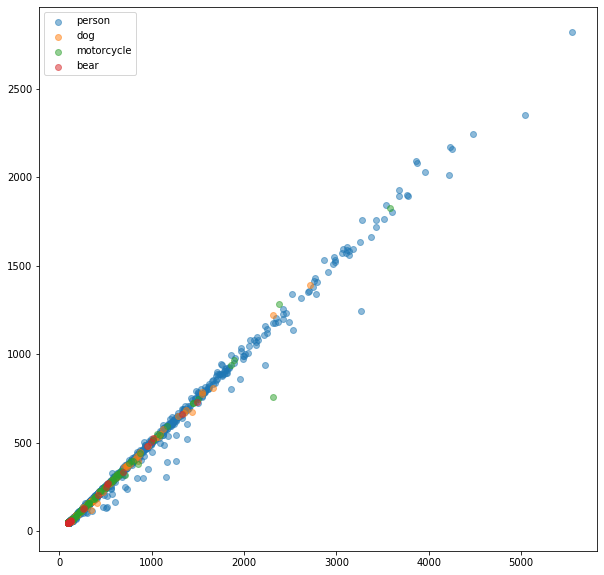

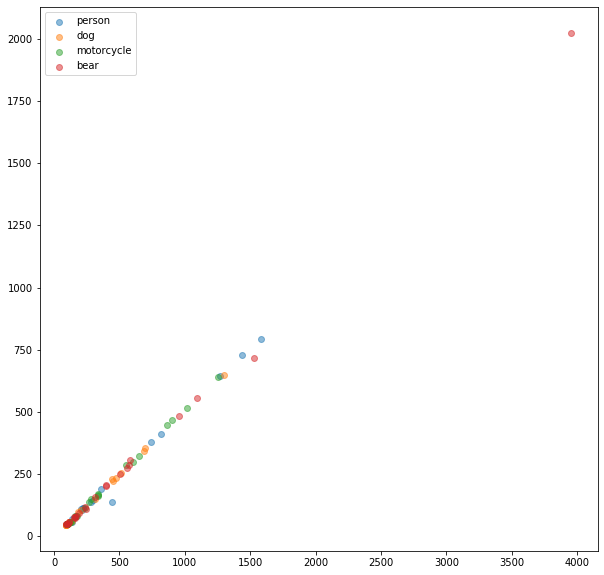

In [10]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(dev_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

#### Cleanup

In [11]:
del model
del train_loader
del dev_loader

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [12]:
# Set up data loaders
from datasets import SiameseImage

siamese_train_dataset = SiameseImage(train_dataset, True) # Returns pairs of images and target same/different
siamese_dev_dataset = SiameseImage(dev_dataset, False)
batch_size = 2
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_dev_loader = torch.utils.data.DataLoader(siamese_dev_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [13]:
fit(siamese_train_loader, siamese_dev_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/2953 (0%)]	Loss: 0.476688


RuntimeError: CUDA out of memory. Tried to allocate 978.00 MiB (GPU 0; 10.73 GiB total capacity; 9.80 GiB already allocated; 37.19 MiB free; 90.09 MiB cached)

In [ ]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(dev_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)